# Final Project - Personal

## Student Info
Name: Siyuan Wu

## Topic: Learning Environment and User Participation Patterns on a Chinese Learning Website

I choose this topic for my assessment because Chinese is my mother tongue, and it is relatively difficult to learn for non-native speakers compared to languages like English. I'm looking forward to have a view of how non-native speakers think of Chinese as a language, what they talk about most frequently about it, and also how they participate in this chinese-learning website in order to learn more about Chinese.

My assessment consists of four research questions:

Firstly there will be a fundamental analysis to find out the most frequently used tags in the website. After that a sentiment analysis of several specific tags is made to have a deeper insight into how people feel with those particular topics. Then it'll find out what's the most popular tags in each year in order to know what topics are the hottest. Finally I'll compare those tags that have the highest sentiment compound with those that are talked about the most frequently to see whether they are the same or not.

The data I will be using is a data package from stack exchange archive website named chinese.stackexchange.com.

# Code and Analysis

## The most frequently used tags

In the following code, I'm going to filter out the top 20 tags that were most frequently used on the website from 2011 to 2020. The tags are ranked in descending order.

In [1]:
import pandas as pd
import bs4
import xmltodict
from os import sep

with open(f'Tags.xml','rb') as infile:
    chi_doc = xmltodict.parse(infile.read().decode())
    
chi_df = pd.json_normalize(chi_doc['tags']['row'])

chi_df.columns = ['Id', 'TagName', 'Count', 'ExcerptPostId', 'WikiPostId']
print("{} tags have been used in the website.\n".format(len(chi_df)))

for i in range(len(chi_df)):
    chi_df.iloc[i]['Count'] = int(chi_df.iloc[i]['Count'])

chi_df.set_index('Count', inplace=True)
chi_df_sorted = chi_df.sort_index(axis=0, ascending=False)

top20_s = chi_df_sorted.head(20)['TagName']
top20_df = pd.DataFrame(top20_s)
top20_df.columns = ['TagName']

top20_df['Count'] = top20_df.index
top20_df.index = range(1,21)

print("The following dataframe shows the top 20 tags in frequency. Tagname and their number of appearance are listed below:")
display(top20_df)

161 tags have been used in the website.

The following dataframe shows the top 20 tags in frequency. Tagname and their number of appearance are listed below:


,TagName,Count
1,translation,1809
2,grammar,1403
3,meaning,1196
4,word-choice,759
5,usage,662
6,meaning-in-context,618
7,mandarin,603
8,difference,590
9,characters,551
10,vocabulary,457


## Sentiment analysis for the posts that have certain tags

As we can see in the dataframe displayed above, the tags with the highest frequency are those related to linguistics, such as grammar, usage, vocabulary, as well as those related to language application, such as translation, meaning. These tags are universal and common to see in many language learning websites no matter what language they are talking about.

However, there are also some tags that are typical for the Chinese language only. I'd like to look at the sentiment of the posts which have the tags of 'madarin', 'cantonese' or 'simplified-chinese'.

There are many different kinds of dialects in China and each has a distinct set of pronunciation rules of its own. In order to talk to each other more conveniently, people use mandarin in their daily communications in case they couldn't understand the other person's dialect. Mandarin is the official oral language in China, and it is most widely used in official occasions such as schools and corporations. A foreign language learner must know about mandarin as soon as he or she start learning Chinese. Cantonese is a dialect from Guangzhou, China. Many pop songs that are pronounced in cantonese are not only wildly known in China but also familiar to many music lovers abroad. Although mandarin and cantonese are well known among foreign learners for different reasons, it's interesting to see what's the difference in altitude of the users on the website towards the two.

Furthermore, due to China's long history, the written version of Chinese today is greatly different from that in the ancient times. As a result, in contast to 'simplified-chinese' that we use in everyday life, there is also 'classical-chinese' that represents how our ancestors wrote Chinese back then. Generally, classical-chinese is much more difficult to understand than simplified-chinese. So it may be interesting to see how foreign learners think of the two versions of written Chinese. Though classical-chinese is not among the top 20 list of tags, I include it in the sentiment analysis to serve as a camparison to simplified-chinese in order to see the difference between them.

I'll be using the vaderSentiment package in the following analysis. A discussion about the strength and drawbacks of this package will be covered later in the 'Conclusion and Discussion' part at the end of this essay.

In [2]:
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

In [3]:
# Get all the data into a dataframe
with open(f'Posts.xml','rb') as infile:
    user_doc = xmltodict.parse(infile.read().decode())
    
user_df = pd.json_normalize(user_doc['posts']['row'])

In [4]:
# Parse the column of Body to get rid of redundant characters.
# Create a new column called 'Clean_body' to store the cleaned data.
import bs4 

def robustParse(text,replaceNL=True):    
    try: 
        if replaceNL: NL = "\n"
        else: NL = " "
        return bs4.BeautifulSoup(text, "lxml").text.replace(f"{NL}"," ")
    except: 
        return None 
    
user_df["Clean_body"] = user_df["@Body"].map(
    lambda raw_html: robustParse(raw_html))

In [5]:
# Sentiment analysis for each of the tags choosen.
import numpy as np

tags_s = user_df['@Tags']

tags_s.dropna(inplace=True)

l_mandarin = [i for i in tags_s.index if '<mandarin>' in tags_s[i]]
l_cantonese = [i for i in tags_s.index if '<cantonese>' in tags_s[i]]
l_sim = [i for i in tags_s.index if '<simplified-chinese>' in tags_s[i]]
l_classic = [i for i in tags_s.index if '<classical-chinese>' in tags_s[i]]

df_mandarin = pd.DataFrame()
df_cantonese = pd.DataFrame()
df_sim = pd.DataFrame()
df_classic = pd.DataFrame()

for i in l_mandarin:
    df_mandarin = df_mandarin.append(user_df[i:i+1])

for i in l_cantonese:
    df_cantonese = df_cantonese.append(user_df[i:i+1])

for i in l_sim:
    df_sim = df_sim.append(user_df[i:i+1])
    
for i in l_classic:
    df_classic = df_sim.append(user_df[i:i+1])
    
def calc_senti(demo_df):
    demo_df["senti_dict"] = demo_df["Clean_body"].map(
        lambda bodytext: analyzer.polarity_scores(bodytext))
    demo_df["senti_pos"] = demo_df["senti_dict"].map(lambda x: x["pos"])
    demo_df["senti_neg"] = demo_df["senti_dict"].map(lambda x: x["neg"])
    demo_df["senti_neu"] = demo_df["senti_dict"].map(lambda x: x["neu"])
    demo_df["senti_compound"] = demo_df["senti_dict"].map(lambda x: x["compound"])
    del demo_df["senti_dict"]

for i in [df_mandarin, df_cantonese, df_sim, df_classic]:
    calc_senti(i)

# display(df_mandarin[['Clean_body',"senti_pos","senti_neg","senti_neu","senti_compound"]].head(3))
# display(df_cantonese[['Clean_body',"senti_pos","senti_neg","senti_neu","senti_compound"]].head(3))
# display(df_sim[['Clean_body',"senti_pos","senti_neg","senti_neu","senti_compound"]].head(3))
# display(df_classic[['Clean_body',"senti_pos","senti_neg","senti_neu","senti_compound"]].head(3))


In [6]:
# Calculate the average sentiment compound to reflect the users' sentiment to each tag.
l_senti_result = [['mandarin', df_mandarin['senti_compound'].mean()],
                  ['cantonese', df_cantonese['senti_compound'].mean()],
                  ['simplified-chinese', df_sim['senti_compound'].mean()],
                  ['classical-chinese', df_classic['senti_compound'].mean()]]

df_senti_result = pd.DataFrame(l_senti_result)

df_senti_result.columns = ["Tag", "Average_Senti_compound"]

df_senti_result.set_index('Tag', inplace=True)

display(df_senti_result)

,Average_Senti_compound
Tag,
mandarin,0.281313
cantonese,0.233183
simplified-chinese,0.337300
classical-chinese,0.338220


From the dataframe above, we can find out that users have a more positive sentiment towards mandarin compared to cantonese. This might due to the difference in pronunciation. Mandarin sounds much softer and smoother while cantonese a bit rougher and harsher, so that it's more likely for a foreigner who couldn't understand the meaning of the language at first to prefer mandarin to cantonese. Other reason might be that most Chinese teaching institutions only teach mandarin, thus making cantonese harder to learn for beginners. Despite the small difference in the scores, the overall attitude is positive, which shows the relative positive mind when they are talking about topics related to either mandarin and cantonese. It's good to see these results on a language learning website.

Meanwhile, 'simplified-chinese' and 'classical-chinese' does not differ in aspect of the sentiment compound, which is a bit surprising because classical-chinese is more difficult to learn than simplified-chinese even for students in China. The close scores represents the users' positive altitude towards not only the current version of written Chinese but also the ancient one, which serves as a sign of inclusiveness and the eagerness to learn.

## What's the most popular tags in each year?

For the tags on a website, they were sometimes very hot and were used very frequently by the users in a year, while in other years they might not be used for so many times. In the following part, there will be an analysis on the number of times each tag has been used in a year in order to find out whether some tags were popular over time while others were just hot in a particular year.

In [7]:
import bs4 
import pandas as pd
from os import sep
from datetime import datetime
import re

def make_stack_df(df_path,COLS,set_index_col=False,verbose=False):
    """Helper function for turning StackExchange XML into DataFrame"""
    
    text = open(df_path,'rb').read().decode("utf-8")

    if verbose: print("Text loaded")
    soup = bs4.BeautifulSoup(text, "lxml")
    if verbose: print("Soup processed")

    rows = []
    for c,i in enumerate(soup.find_all('row')):
        temprow = []
        for key in COLS: 
            if key in i.attrs:  temprow.append(i.attrs[key])
            else:               temprow.append( pd.NA )
                
        rows.append(temprow)

    stack_df = pd.DataFrame(rows,columns = COLS)

    if set_index_col != False: 
        stack_df.set_index(stack_df[set_index_col],inplace=True,drop=True)

    return stack_df

posts_path = f"Posts.xml"

COLS_posts = ['creationdate', 'id', 'owneruserid', 'parentid',
            'posttypeid', 'tags', 'body']

In [8]:
posts_df = make_stack_df(posts_path,COLS_posts,set_index_col="id")
posts_df = posts_df[posts_df["owneruserid"].notna()]

posts_df["Clean_body"] = posts_df["body"].map(
    lambda raw_html: robustParse(raw_html))

In [9]:
question_mask = posts_df["posttypeid"]=="1"
answer_mask = posts_df["posttypeid"]=="2"

with_owner_df = posts_df[answer_mask].merge(posts_df[["owneruserid"]],
                                            left_on="parentid",
                                            right_index=True,
                                            suffixes=["_a","_q"])

with_owner_df_tags = with_owner_df.merge(posts_df[["tags"]],
                                         left_on='parentid',
                                         right_index=True,
                                         suffixes=["_ori",''])

del with_owner_df_tags['tags_ori']
del with_owner_df_tags['body']

In [10]:
cols= ["creationdate"]

for i in cols: 
    with_owner_df_tags["{}".format(i)] = with_owner_df_tags[i].map(
        lambda datetext: datetime.strptime(datetext, 
                                           '%Y-%m-%dT%H:%M:%S.%f') )
    
l_tags = [i for i in chi_df_sorted['TagName']]

In [11]:
tag_finder = re.compile("<[\w-]*>")
with_owner_df_tags['retags'] = with_owner_df_tags['tags'].fillna("").map(
                                                lambda x: [i[1:-1] for i in tag_finder.findall(x)])

temp_df = with_owner_df_tags['retags'].apply(pd.Series)

try: 
    temp_df = temp_df.rename(columns = lambda x : 'tag_' + str(x+1))
    temp_df.fillna(pd.NA,inplace=True)
except TypeError:
    pass

tags_df = temp_df.merge(with_owner_df_tags[["creationdate","id","posttypeid","Clean_body"]],
                        left_index=True, right_index=True,how="left")

In [12]:
rowtags_df = tags_df.melt(id_vars = ['creationdate',"id","posttypeid","Clean_body"], value_name = "tag")

rowtags_df.dropna(inplace=True)

del rowtags_df["variable"]

rowtags_df.sort_values("id", inplace=True)

In [13]:
list_of_tags = []

for i in range(2011, 2021):
    time_mask = rowtags_df['creationdate'].dt.year==i
    t_m_df = rowtags_df[time_mask]

    for j in l_tags:
        tag_mask = t_m_df["tag"]==j
        tt_m_df = t_m_df[tag_mask]
        list_of_tags.append([i, j, len(tt_m_df)])

In [14]:
df_of_tags = pd.DataFrame(list_of_tags, columns = ["year", "tag", "count"])

# display(df_of_tags.head())

In [15]:
l_top_tags = []

for i in range(2011, 2021):
    year_mask = df_of_tags["year"]==i
    tmp_df = df_of_tags[year_mask].sort_values(by=['count'], axis=0, ascending=False)
    l_top_tags.append([i for i in tmp_df['tag'][:5]])

df_top_tags = pd.DataFrame(l_top_tags, columns = ['No.1', 'No.2', 'No.3', 'No.4', 'No.5'])

df_top_tags.index = range(2011, 2021)

df_top_tags.index_name = "year"

print("The following table shows the most popular tags in each year:\n")

display(df_top_tags)

The following table shows the most popular tags in each year:



,No.1,No.2,No.3,No.4,No.5
2011,mandarin,pronunciation,characters,word-choice,grammar
2012,word-choice,mandarin,meaning,grammar,translation
2013,translation,grammar,word-choice,meaning,vocabulary
2014,translation,grammar,vocabulary,word-choice,meaning
2015,translation,meaning,grammar,difference,usage
2016,translation,grammar,meaning,word-choice,characters
2017,translation,meaning,grammar,meaning-in-context,word-choice
2018,grammar,translation,word-choice,meaning,meaning-in-context
2019,translation,grammar,meaning,usage,word-choice
2020,grammar,translation,meaning,meaning-in-context,sentence-structure


As we can see in the table above, tags like 'translation', 'grammar', 'meaning', 'word-choise' have been most frequently talked about throughout the decade, while tags like 'mandarin', 'difference', 'vocabulary', 'sentence-structure', 'usage', 'characters' are only popular in one or two years.

## Do the most popular tags also have the most positive score in the sentiment analysis?

This time we're going to find out if the most popular tags are necessarily the most positive in sentiment analysis.

The following graph gives an overall view of the distribution of the sentiment compound over the decade. The x-axis refers to the distribution of the sentiment compound. The y-axis refers to the frequency of a sentiment compound (range).

In [16]:
user_df_new = user_df[['@Id', '@CreationDate', 'Clean_body']]
user_df_new.columns = ['id', 'creationdate', 'Clean_body']
# display(user_df_new.head())

In [17]:
import warnings
warnings.filterwarnings("ignore")

calc_senti(user_df_new)

In [18]:
user_df_new["creationdate"] = user_df_new["creationdate"].map(
        lambda datetext: datetime.strptime(datetext, '%Y-%m-%dT%H:%M:%S.%f') )

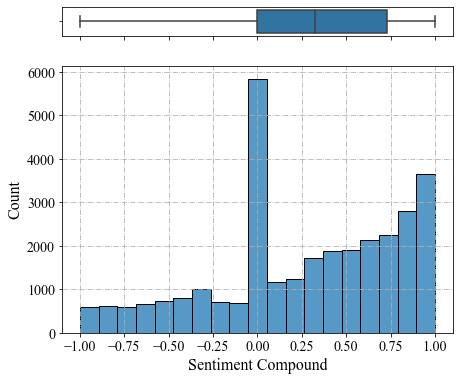

In [29]:
# This gives an overall view of the distribution of the sentiment compound.
import seaborn as sns
import matplotlib.pyplot as plt

plt.rc('font',family='Times New Roman')
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw={"height_ratios": (.1, .9)}, figsize=[7,6])

sns.boxplot(user_df_new["senti_compound"], ax=ax_box)
sns.histplot(user_df_new["senti_compound"], bins=19, ax=ax_hist)

plt.grid(linestyle='-.');
ax_box.set(xlabel='');
plt.xlabel('Sentiment Compound', fontdict={'family':'Times New Roman', 'size':16});
plt.ylabel('Count', fontdict={'family':'Times New Roman', 'size':16});
plt.yticks(fontproperties = 'Times New Roman', size = 14);
plt.xticks(fontproperties = 'Times New Roman', size = 14);

The boxplot on the top (horizontal) shows that the average sentiment compound is about 3.5. Most posts (about 75%) have positive sentiment coumpound, which indicates the positive mind of the users when they talk about the topics on the website. Meanwhile, in the histplot below, we may find that higher sentiment compound have a higher frequency in general. This is also a good sign indicating that the users on the website is writing posts in a friendly and positive attitude.

In [20]:
calc_senti(rowtags_df)

In [21]:
tag_list = [i for i in chi_df_sorted["TagName"]]

senti_of_tags_list = []

for y in range(2011, 2021):
    y_m = rowtags_df["creationdate"].dt.year==y
    year_masked = rowtags_df[y_m]
    for t in tag_list:
        t_m = year_masked["tag"]==t
        tag_masked = year_masked[t_m]
        senti_of_tags_list.append([t, str(y), tag_masked['senti_compound'].mean()])
        
senti_tag_year = pd.DataFrame(senti_of_tags_list)

In [22]:
tags_e = [i for i in chi_df_sorted.head(95)["TagName"]]

In [23]:
senti_tag_year.columns = ["tag", "year", "average_senti_compound"]
# display(senti_tag_year)

In [24]:
posi_l = []
nega_l = []

for y in range(2011, 2021):
    y_m = senti_tag_year['year']==str(y)
    tmp_df = senti_tag_year[y_m]
    fin_df = pd.DataFrame()
    
    for i in range(len(tmp_df)):
        if tmp_df.iloc[i][0] not in tags_e:
            continue
        fin_df = fin_df.append(tmp_df[i:i+1])
    # display(fin_df)    
    
    fin_df_pos = fin_df.sort_values(by=['average_senti_compound'], axis=0, ascending=False)
    # display(fin_df_pos.head())
    fin_df_neg = fin_df.sort_values(by=['average_senti_compound'], axis=0, ascending=True)
    # display(fin_df_neg.head())
    
    posi_l.append([i for i in fin_df_pos.head(5)['tag']])
    nega_l.append([i for i in fin_df_neg.head(5)['tag']])
    
pos_df = pd.DataFrame(posi_l, columns = ["No.1", "No.2", "No.3", "No.4", "No.5"])
pos_df.index = range(2011, 2021)
neg_df = pd.DataFrame(nega_l, columns = ["No.1", "No.2", "No.3", "No.4", "No.5"])
neg_df.index = range(2011, 2021)

print("The analysis only take those tags that has been used for no less than 20 times throughout the past decade into consideration.")

print("\nThe most positive tags in each year:")
display(pos_df)

print("\nThe most negative tags in each year:")
display(neg_df)

print("\nA copy of the most popular tags in each year:")
display(df_top_tags)

The analysis only take those tags that has been used for no less than 20 times throughout the past decade into consideration.

The most positive tags in each year:


,No.1,No.2,No.3,No.4,No.5
2011,idioms,pronouns,terms-of-address,mainland-china,phrase-request
2012,greetings,phrase-request,slang,names,learning
2013,comparison,literary-chinese,greetings,calligraphy,reading
2014,internet-slang,books,greetings,word-order,hsk
2015,fonts,old-chinese,mainland-china,terms-of-address,learning
2016,stroke-order,internet-slang,greetings,learning,loanwords
2017,proverb,seal,poetry,learning,politeness
2018,greetings,listening,colloquialisms,proverb,equivalent-phrase
2019,spelling,software,synonyms,input-methods,listening
2020,terms-of-address,hong-kong,proverb,learning,classical-chinese



The most negative tags in each year:


,No.1,No.2,No.3,No.4,No.5
2011,internet-slang,word,glyph-origin,equivalent-phrase,meaning
2012,internet-slang,listening,particles,lyrics,preposition
2013,adverbs,adjectives,transliteration,slang,mainland-china
2014,poetry,place-names,number,phonology,old-chinese
2015,character-components,measure-word,literary-chinese,hsk,lyrics
2016,character-components,slang,hong-kong,handwriting,number
2017,books,internet-slang,ambiguity,punctuation,phrase-meaning
2018,calligraphy,sandhi,syntax,slang,lyrics
2019,slang,sandhi,adjectives,character-components,old-chinese
2020,colloquialisms,lyrics,punctuation,internet-slang,idioms



A copy of the most popular tags in each year:


,No.1,No.2,No.3,No.4,No.5
2011,mandarin,pronunciation,characters,word-choice,grammar
2012,word-choice,mandarin,meaning,grammar,translation
2013,translation,grammar,word-choice,meaning,vocabulary
2014,translation,grammar,vocabulary,word-choice,meaning
2015,translation,meaning,grammar,difference,usage
2016,translation,grammar,meaning,word-choice,characters
2017,translation,meaning,grammar,meaning-in-context,word-choice
2018,grammar,translation,word-choice,meaning,meaning-in-context
2019,translation,grammar,meaning,usage,word-choice
2020,grammar,translation,meaning,meaning-in-context,sentence-structure


The data that I have chosen only include those that have been used for no less than 20 times throughout the decade. The reason why I filter the rest tags out is because too little sample might make the margin of error much greater. Thus, in order to get a more accurate result, I only take tags that are at least used for 2 times a year on average into account.

From the tables above, we may find out that the most popular tags each year are not necessarily the highest (or the lowest) in the score of sentiment analysis. Tags such as 'greetings' may have a high score because most greeting words express positive attitudes. Other tags like 'intersting-slang' have very positive sentimental compound in one year, but have a rather low score in another year. This may due to the fact that the tags weren't used for many times so the score might not be so accurate, and the result of sentiment analysis might be influenced by the sentiment of the slang that were queted in the posts. As a result, popular tags and positive tags are not necessarily the same.

# Conclusion and Discussion

## Conclusions on the learning environment and user participation patterns

After a series of analysis, we are able to find out that this Chinese learning website has a generally good environment for studying as most of the posts online have positive sentiment compound. There is a stable pattern in the most popular tags over the ten years from 2011 to 2020, while the tags that have the highest or lowest score in sentiment analyis might change dramatically over time. Users on the website are generally interested in the Chinese language and are eager to learn Chinese well.
The users are not necessarily focused on those topics that use tags which have the highest score of sentiment compound. Nor aren't the most popular tags the least positive. Half of the posts on the website have the sentiment compound ranging from 0 to 0.75, which indicates the website offers a rather friendly learning environment for language learners.

## Prospect of futher research

If further research is to be carried out, analysts may focus on different groups of users, categorizing them by age, gender or nationality, to find the difference in user behaviour between them.

The method of sentiment analysis can also be improved in order to eliminate the impact of quoted sentences such as slang and proverbs on the value of sentiment compound.

## About the dictionary-based NPL: vader sentiment analysis package

Vader is a dictionary-based NPL package for sentiment analysis. It makes a series of dictionaries and set up rules to quantify the emotion in the text. It carries out syntactic analysis on the text, calculates the sentiment compound, and finally uses the sentiment compound to represent the emotion of the text.

As a wildly used package, vader has several strength in sentiment analysis. It focuses on those particular words that indicate the emotion of the user. When analyzing short texts such as the posts on the websites, it performs well as the structure of the sentence may not be too complicated.

However, when the text grows longer and the structure of the text and the sentences becomes more complicated, the dictionary-based method might face some difficulties. Just as I've mentioned in the 'Code and Analysis' section above, the sentiment compound may be affected by the quotes in the sentence, though they do not necessarily reflect the users' emotion. In those cases, machine learning may be helpful in dealing with longer paragraphs, as it does not focus on single words but views the text as a whole instead.

In further research, it might help if multiple methods of NPL are used to find out a better way of sentiment analysis.

## Data quality

The data used in this essay are all within ten years from now, so the timeliness of the data can be guaranteed. While wrangling all the data from the dataset, I met with a few NaN values. But it had little effect on further analysis after I removed them, as most of the information was complete. However, whether the data in the dataset cover every post on the website or they are only a subset of the total data remains to be discussed. If more data can be accessed, the result of the analysis may be more persuasive.